# Prep all data

In [1]:
import pandas as pd
import duckdb
connection = duckdb.connect(database=':memory:', read_only=False)

capacity_df = pd.read_parquet(r'C:\Users\lt0828\Desktop\PhD\p3\nu1000_model\gcmc\files\trappe_ff\mix.parquet')
capacity_df = capacity_df.loc[:, ['p', 'temperature', 'adsorption_type', 'mol_uc_avg', 'component_num']]
capacity_df = capacity_df.astype({'p': int, 'temperature': int, 'component_num': int, 'mol_uc_avg': float,
                                  'adsorption_type': 'category'})

capacity_df['alken'] = capacity_df['component_num'].apply(lambda x: f'C{(x+1)*2}').astype(str) + \
                            capacity_df['adsorption_type'].apply(lambda x: '' if x == 'absolute' else '_out').astype(str)
print(capacity_df.shape)
s = """
with t1 as (
SELECT * FROM capacity_df where adsorption_type = 'absolute'),
t2 as (
SELECT * FROM capacity_df where adsorption_type = 'excess'),
t3 as (
select t2.*, t1.mol_uc_avg - t2.mol_uc_avg as capacity from t1 join t2 on t1.temperature = t2.temperature 
and t1.component_num = t2.component_num and t1.p = t2.p)

select *, mol_uc_avg as capacity from capacity_df where adsorption_type = 'absolute'
union
select t3.*from t3
order by temperature, p, component_num, adsorption_type
"""
capacity_df = connection.execute(s).fetchdf()
capacity_df.to_pickle('../files/processed_data/capacity_df.pkl')
capacity_df.query('temperature == 300 and p == 100000').head(2)

(1210, 6)


,p,temperature,adsorption_type,mol_uc_avg,component_num,alken,capacity
0,100000,300,absolute,1.554528,0,C2,1.554528
1,100000,300,excess,1.458681,0,C2_out,0.095847


In [2]:
distribution = pd.read_pickle(r'C:\Users\lt0828\Desktop\PhD\p3\nu1000_model\gcmc\files\clusterization\distribution.pkl')\
    .drop(columns=['atom_name']).rename(columns={'T': 'temperature'})
distribution['alken'] = distribution['n'].apply(lambda x: f'C{x}').astype(str)
distribution = distribution[~distribution.file.str.contains('lowT')]
s = '''
with t1 as (
select * from distribution where cluster = 0),
t2 as (
    select d.*, d.N_mol / t1.N_mol as ratio from distribution as d
    left join t1 using(alken, p, temperature))

select * from t2 where cluster == 1
'''
distribution_df = connection.execute(s).fetchdf()
distribution_df.to_pickle('../files/processed_data/distribution_df.pkl')
distribution_df.head(2)

,file,cluster,N_mol,p,temperature,n,G,alken,ratio
0,mixtures_hf/p_100000_T_300/Movies/System_0/Mov...,1,174113,100000,300,2,-0.147839,C2,1.281458
1,mixtures_hf/p_100000_T_300/Movies/System_0/Mov...,1,3830784,100000,300,4,0.083982,C4,0.868594


c:\Users\lt0828\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LassoCV was fitted with feature names
  warnings.warn(


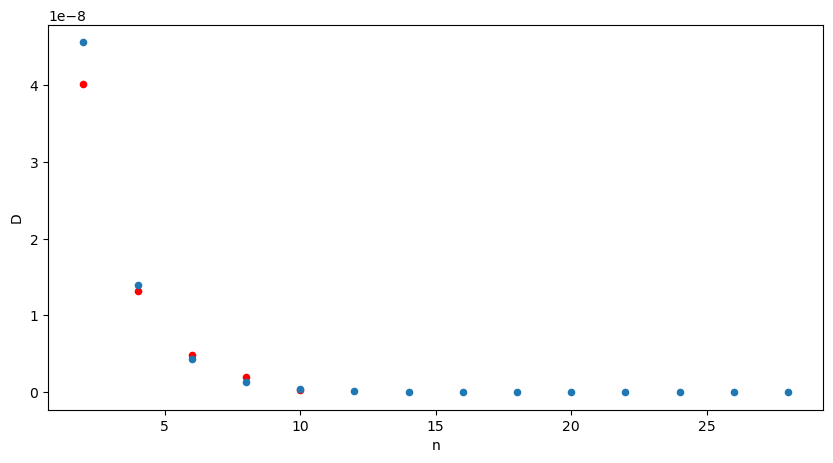

In [3]:
import numpy as np
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
diffusions = pd.DataFrame({'n': [2, 4, 6, 8, 10], 
                           'D': [4.010918e-08, 1.324638e-08, 4.875015e-09, 2.026042e-09, 2.767088e-10]})

diffusions['logd'] = diffusions['D'].apply(lambda x: np.log10(x))
diffusions.plot(x='n', y='D', kind='scatter', ax=ax, color='red')
model = LassoCV()
model.fit(diffusions[['n']], diffusions['logd'])

# Predict logD up to n = 28 and calculate D
n_pred = np.arange(2, 29, 2)
logd_pred = model.predict(n_pred.reshape(-1, 1))
D_pred = 10**logd_pred

# Create DataFrame for the prediction
diffusion_pred = pd.DataFrame({'n': n_pred, 'D': D_pred, 'logd_pred': logd_pred})
diffusion_pred.plot(x='n', y='D', kind='scatter', ax=ax)
diffusions = pd.concat([diffusions, diffusion_pred])
diffusions.to_pickle('../files/processed_data/diffusion.pkl')

c:\Users\lt0828\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LassoCV was fitted with feature names
  warnings.warn(


<Axes: xlabel='n', ylabel='capacity'>

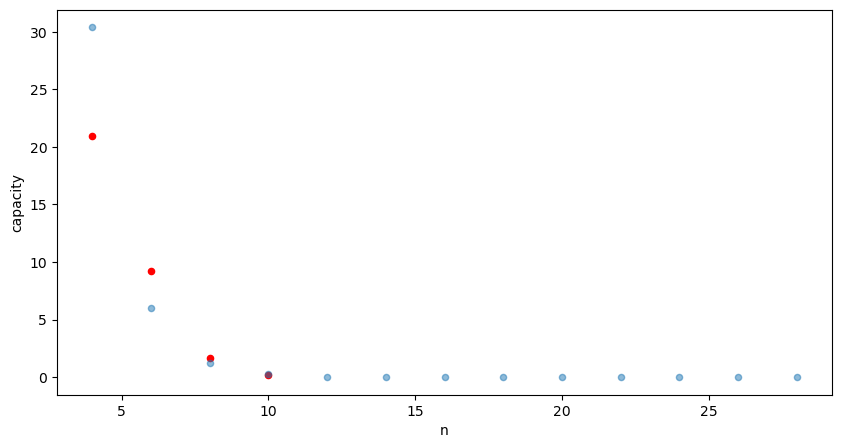

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
df = capacity_df.query('temperature == 300 and p == 100000 and adsorption_type == "absolute" and component_num > 0')\
    [['mol_uc_avg', 'component_num']]
df['n'] = df['component_num'].apply(lambda x: (x+1) * 2)
df['log_capacity'] = np.log10(df['mol_uc_avg'])
df.plot(x='n', y='mol_uc_avg', kind='scatter', ax=ax, color='red')
model = LassoCV(cv=4)
model.fit(df[['n']], df['log_capacity'])

# Predict logD up to n = 28 and calculate D
n_pred = np.arange(4, 29, 2)
log_capacity_pred = model.predict(n_pred.reshape(-1, 1))
capacity_pred = 10**log_capacity_pred
capacity_pred = pd.DataFrame({'n': n_pred, 'capacity': capacity_pred})
capacity_pred['adsorption_type'] = 'absolute'

capacity_pred.plot(x='n', y='capacity', kind='scatter', ax=ax, alpha=0.5)

In [5]:
capacity_pred = pd.concat([capacity_pred, pd.DataFrame({'n': n_pred, 'capacity': 17.817100, 'adsorption_type': 'excess'})], axis=0)
capacity_pred.loc[-1] = [2, 1.554528, 'absolute']
capacity_pred.loc[-2] = [2, 0.095847, 'excess']

capacity_pred['component_num'] = capacity_pred['n'].apply(lambda x: (x-2)/2)
capacity_pred['temperature'] = 300
capacity_pred['p'] = 100000
capacity_pred['mol_uc_avg'] = capacity_pred['capacity']

capacity_pred['alken'] = capacity_pred['component_num'].apply(lambda x: f'C{int(x+1)*2}').astype(str) + \
                            capacity_pred['adsorption_type'].apply(lambda x: '' if x == 'absolute' else '_out').astype(str) 
capacity_pred = capacity_pred.sort_values(by=['n', 'adsorption_type']).reset_index(drop=True)

capacity_pred = pd.concat([capacity_df.query('temperature == 300 and p == 100000'), 
                           capacity_pred.query('n>10')])

capacity_pred.to_pickle('../files/processed_data/capacity_pred.pkl')
capacity_pred.head(2)

,p,temperature,adsorption_type,mol_uc_avg,component_num,alken,capacity,n
0,100000,300,absolute,1.554528e+00,0.0,C2,1.554528e+00,NaN
1,100000,300,excess,1.458681e+00,0.0,C2_out,9.584685e-02,NaN
2,100000,300,absolute,2.090612e+01,1.0,C4,2.090612e+01,NaN
3,100000,300,excess,2.081027e+01,1.0,C4_out,9.584595e-02,NaN
4,100000,300,absolute,9.203780e+00,2.0,C6,9.203780e+00,NaN
5,100000,300,excess,-8.613318e+00,2.0,C6_out,1.781710e+01,NaN
6,100000,300,absolute,1.658310e+00,3.0,C8,1.658310e+00,NaN
7,100000,300,excess,-1.615878e+01,3.0,C8_out,1.781709e+01,NaN
8,100000,300,absolute,1.630750e-01,4.0,C10,1.630750e-01,NaN
9,100000,300,excess,-1.765403e+01,4.0,C10_out,1.781710e+01,NaN


### Profile

In [56]:
import joblib
def read_file(file):
    df = pd.read_csv(file, sep='\s+', skiprows=1, header=None)
    df.columns = ['E', 'type', 'state']
    return df

def energy_diff(init_state, final_state, df):
    E = df.query(f'state == "{init_state}"')['E'].values
    if len(E) != 1:
        raise ValueError(f'{init_state} not found in the dataframe or there is more than one entry')
    init_state_energy = E[0]
    E = df.query(f'state == "{final_state}"')['E'].values
    if len(E) != 1:
        raise ValueError(f'{final_state} not found in the dataframe or there is more than one entry')
    final_state_energy = E[0]
    return final_state_energy - init_state_energy

def make_energies(df):
    energies = {'c2_adsorption': energy_diff('4', '5', df),
    'c2_desorbtion': energy_diff('5', '4', df),
    'c2_attaching': energy_diff('0', '1', df),
    'c2_deattaching': energy_diff('1', '0', df),
    'c2_insertion': energy_diff('1', '1,2', df),
    'c2_deinsertion': energy_diff('2', '1,2', df),
    'c4_deattaching': energy_diff('2', '2,3', df),
    'c4_attaching': energy_diff('3', '2,3', df),
    'c4_adsorption': energy_diff('4', '3', df),
    'c4_desorbtion': energy_diff('3', '4', df)}
    return energies

file = r'../files\raw_data\EtDimer_data\Cr3_PBED3BJ_fm_G_Truhlar.dat'
df = read_file(file)
energies = make_energies(df)
joblib.dump(energies, '../files/processed_data/CrIII_energies.pkl')
df.to_pickle('../files/processed_data/CrIII.pkl')

file = r'../files\raw_data\EtDimer_data\Cr2_PBED3BJ_fm_G_Truhlar.dat'
df = read_file(file)
energies = make_energies(df)
joblib.dump(energies, '../files/processed_data/CrII_energies.pkl')
df.to_pickle('../files/processed_data/CrII.pkl')

file = r'../files\raw_data\EtDimer_data\Ni_PBED3BJ_fm_G-Truhlar.dat'
df = read_file(file)
energies = make_energies(df)
joblib.dump(energies, '../files/processed_data/Ni_energies.pkl')
df.to_pickle('../files/processed_data/Ni.pkl')

# Reaction

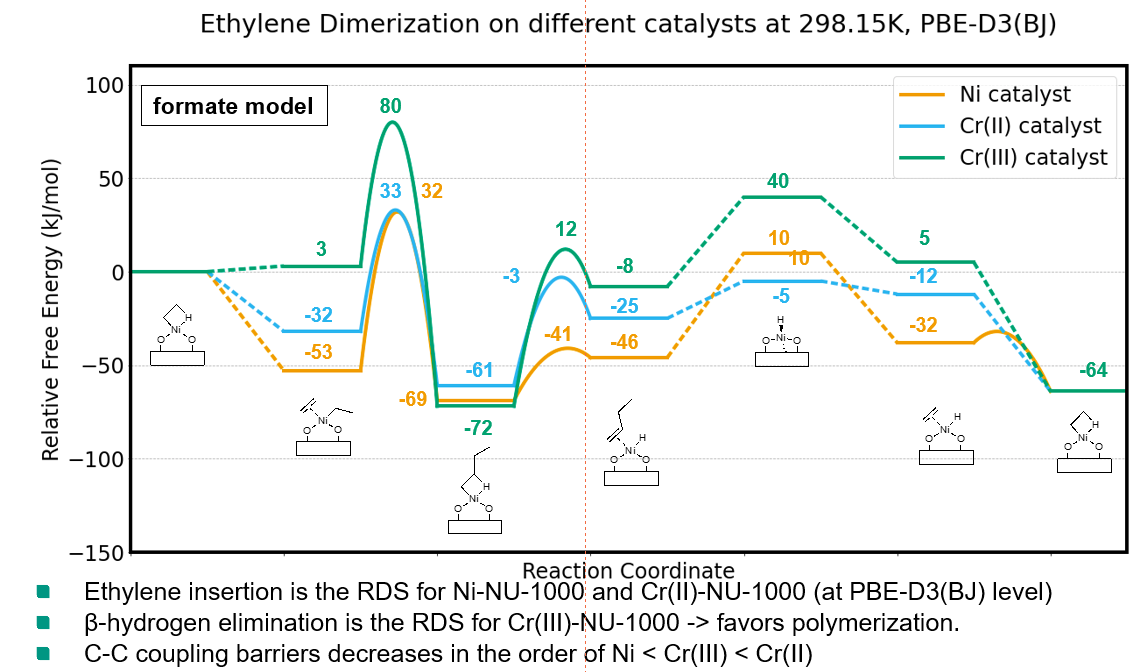

## Make reaction list

In [84]:
def insertion(n, k_ins, k_deins):
    return [f'CatC{n} + C2 <-> CatC{n+2}', k_ins, k_deins]

def deattaching(n, k_deattaching, k_attaching):
    return [f'CatC{n} <-> Cat_C{n}', k_deattaching, k_attaching]

def adsorption(n, k_adsorption, k_desorption):
    return [f'Cat_C{n} -> Cat::C{n}', k_adsorption, k_desorption]

def deorientation(n, k_deorientation, k_orientation):
    return [f'Cat::C{n} <-> Cat + C{n}', k_deorientation, k_orientation]

def diffusion(n, k_diffusion_dict):
    return [f'C{n} <-> C{n}_out', k_diffusion_dict[f'k_diffusion_{n}']]

def make_reactions(n, k_adsorption, k_desorption, k_deorientation, k_orientation, 
                   k_ins, k_deins, k_deattaching, k_attaching, k_diffusion_dict):
    
    reactions = [adsorption(n, k_adsorption, k_desorption), deorientation(n, k_deorientation, k_orientation), 
                 diffusion(n, k_diffusion_dict), insertion(n, k_ins, k_deins), deattaching(n, k_deattaching, k_attaching)]
    
    return reactions


,n,D,logd_pred
0,2,4.559825e-08,-7.341052
1,4,1.398534e-08,-7.854327
2,6,4.289411e-09,-8.367602
3,8,1.315596e-09,-8.880878
4,10,4.035034e-10,-9.394153
5,12,1.237576e-10,-9.907428
6,14,3.795742e-11,-10.420703
7,16,1.164183e-11,-10.933979
8,18,3.570641e-12,-11.447254
9,20,1.095143e-12,-11.960529


In [120]:
diffusion_pred = pd.read_pickle('../files/processed_data/diffusion_pred.pkl')
capacity_pred = pd.read_pickle('../files/processed_data/capacity_pred.pkl')

L = 20 #nm
n = L/3
diffusion_pred['flux'] = diffusion_pred['D'] / (L * 1e-9)
diffusion_dict = diffusion_pred.set_index('n')['flux'].to_dict()

crII = joblib.load('../files/processed_data/CrIII_energies.pkl')
ni = joblib.load('../files/processed_data/Ni_energies.pkl')
ni

{'c2_adsorption': -47.482363519,
 'c2_desorbtion': 47.482363519,
 'c2_attaching': -52.80770185,
 'c2_deattaching': 52.80770185,
 'c2_insertion': 84.38179787,
 'c2_deinsertion': 100.1508549,
 'c4_deattaching': 27.584259009999997,
 'c4_attaching': 4.794457709999996,
 'c4_adsorption': -55.360831699,
 'c4_desorbtion': 55.360831699}

In [121]:
def Eyring_k(G, T=300):
    k = 1.38e-23  # Boltzmann constant (J/K)
    h = 6.626e-34  # Planck's constant (J·s)
    R = 8.314  # Universal gas constant (J/(mol·K))
    
    # G is now in kJ/mol, so we directly use it with R
    return k * T / h * np.exp(-G * 1000 / (R * T))  # Convert kJ to J

def make_known_constants(barriers, T=300):
    k = {}
    k['k_adsorption'] = Eyring_k(barriers['c4_adsorption'], T)
    k['k_desorption'] = Eyring_k(barriers['c4_desorbtion'], T)
    k['k_ins'] = Eyring_k(barriers['c2_insertion'], T)
    k['k_deins'] = Eyring_k(barriers['c2_deinsertion'], T)
    k['k_deattaching'] = Eyring_k(barriers['c4_deattaching'], T)
    k['k_attaching'] = Eyring_k(barriers['c4_attaching'], T)
    return k

def add_diffusion(constants, diffusion):
    d = dict()
    for n in range(2, 29, 2):
        d[f'k_diffusion_{n}'] = diffusion[n]
    constants['k_diffusion_dict'] = d
    return constants

def add_orientation(constants, orientation=1e-2, deorientation=1e2):
    constants[f'k_orientation'] = orientation
    constants[f'k_deorientation'] = deorientation
    return constants

constants = make_known_constants(crII)
constants = add_orientation(constants)

for key, val in constants.items():
    constants[key] = val if val < 1e5 else 1e5

for key, val in constants.items():
    constants[key] = val if val > 1e-5 else 1e-5

constants = add_diffusion(constants, diffusion_dict)

In [122]:
make_reactions(8, **constants)

[['Cat_C8 -> Cat::C8', 100000.0, 22084.180889158088],
 ['Cat::C8 <-> Cat + C8', 100.0, 0.01],
 ['C8 <-> C8_out', 0.06577978159722113],
 ['CatC8 + C2 <-> CatC10', 0.27843197315012236, 1e-05],
 ['CatC8 <-> Cat_C8', 0.01892880156423821, 100000.0]]

# Fit model

# Create Distribution